In [1]:
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
class BasicGEMMExperiment:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device: {self.device}")
        if self.device == 'cuda':
            print(f"GPU: {torch.cuda.get_device_name()}")
            print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    def benchmark_matmul(self, m, k, n, dtype=torch.float16, warmup_runs=5, timing_runs=10):
        """Benchmark matrix multiplication for given dimensions"""
        # Create random matrices
        A = torch.randn(m, k, dtype=dtype, device=self.device)
        B = torch.randn(k, n, dtype=dtype, device=self.device)

        # Warmup
        for _ in range(warmup_runs):
            C = torch.matmul(A, B)
        if self.device == 'cuda':
            torch.cuda.synchronize()

        # Clear memory
        if self.device == 'cuda':
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

        # Time operations
        times = []
        for _ in range(timing_runs):
            if self.device == 'cuda':
                torch.cuda.synchronize()
            start_time = time.perf_counter()
            C = torch.matmul(A, B)
            if self.device == 'cuda':
                torch.cuda.synchronize()
            end_time = time.perf_counter()
            times.append(end_time - start_time)

        # Calculate metrics
        avg_time = np.mean(times)
        operations = 2 * m * n * k
        gflops = operations / (avg_time * 1e9)
        memory_used = 0
        if self.device == 'cuda':
            memory_used = torch.cuda.max_memory_allocated() / (1024**3)

        # Cleanup
        del A, B, C
        if self.device == 'cuda':
            torch.cuda.empty_cache()

        return {
            'time_ms': avg_time * 1000,
            'gflops': gflops,
            'memory_gb': memory_used,
            'm': m, 'k': k, 'n': n
        }

    def test_different_sizes(self, max_size=16384):
        """Test square matrices of different sizes"""
        sizes = []
        current_size = 32
        while current_size <= max_size:
            sizes.append(current_size)
            current_size *= 2
        results = []
        for size in sizes:
            print(f"{size}x{size}:", end="", flush=True)
            try:
                result = self.benchmark_matmul(size, size, size)
                result['size'] = size
                results.append(result)
                print(f"{result['gflops']:.1f} GFLOPS ({result['time_ms']:.1f} ms)")
            except Exception as e:
                print(f"Failed: {e}")
                break

        # Create DataFrame and display as simple table
        df = pd.DataFrame(results)
        print("\nResults:")
        print(df[['size', 'gflops', 'time_ms', 'memory_gb']])
        return df

def plot_size_results(df):
    """Plot performance vs matrix size"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    powers = [int(np.log2(size)) for size in df['size']]
    x_labels = [f'2^{p}' for p in powers]

    # Performance plot
    ax1.loglog(df['size'], df['gflops'], 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Matrix Size (M = K = N)')
    ax1.set_ylabel('Performance (GFLOPS)')
    ax1.set_title('GEMM Performance vs Size')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(df['size'])
    ax1.set_xticklabels(x_labels)

    # Duration plot
    ax2.loglog(df['size'], df['time_ms'], 'o-', color='orange', linewidth=2, markersize=8)
    ax2.set_xlabel('Matrix Size (M = K = N)')
    ax2.set_ylabel('Duration (ms)')
    ax2.set_title('GEMM Duration vs Size')
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(df['size'])
    ax2.set_xticklabels(x_labels)

    plt.tight_layout()
    plt.show()

def run_experiments():
    """Run all the experiments"""
    experiment = BasicGEMMExperiment()
    size_results = experiment.test_different_sizes(max_size=16384)
    plot_size_results(size_results)
    return size_results

Using device: cuda
GPU: Tesla T4
Memory: 15.8 GB
32x32:1.0 GFLOPS (0.1 ms)
64x64:7.8 GFLOPS (0.1 ms)
128x128:61.5 GFLOPS (0.1 ms)
256x256:541.2 GFLOPS (0.1 ms)
512x512:4009.0 GFLOPS (0.1 ms)
1024x1024:11616.1 GFLOPS (0.2 ms)
2048x2048:17071.9 GFLOPS (1.0 ms)
4096x4096:21178.4 GFLOPS (6.5 ms)
8192x8192:22091.3 GFLOPS (49.8 ms)
16384x16384:14878.7 GFLOPS (591.2 ms)

Results:
    size        gflops     time_ms  memory_gb
0     32      0.957756    0.068427   0.007942
1     64      7.802787    0.067192   0.007965
2    128     61.541568    0.068154   0.008057
3    256    541.157747    0.062005   0.008423
4    512   4009.048380    0.066957   0.009888
5   1024  11616.094474    0.184871   0.015747
6   2048  17071.940377    1.006322   0.039185
7   4096  21178.352451    6.489596   0.132935
8   8192  22091.325776   49.771192   0.507935
9  16384  14878.732034  591.185660   2.007935


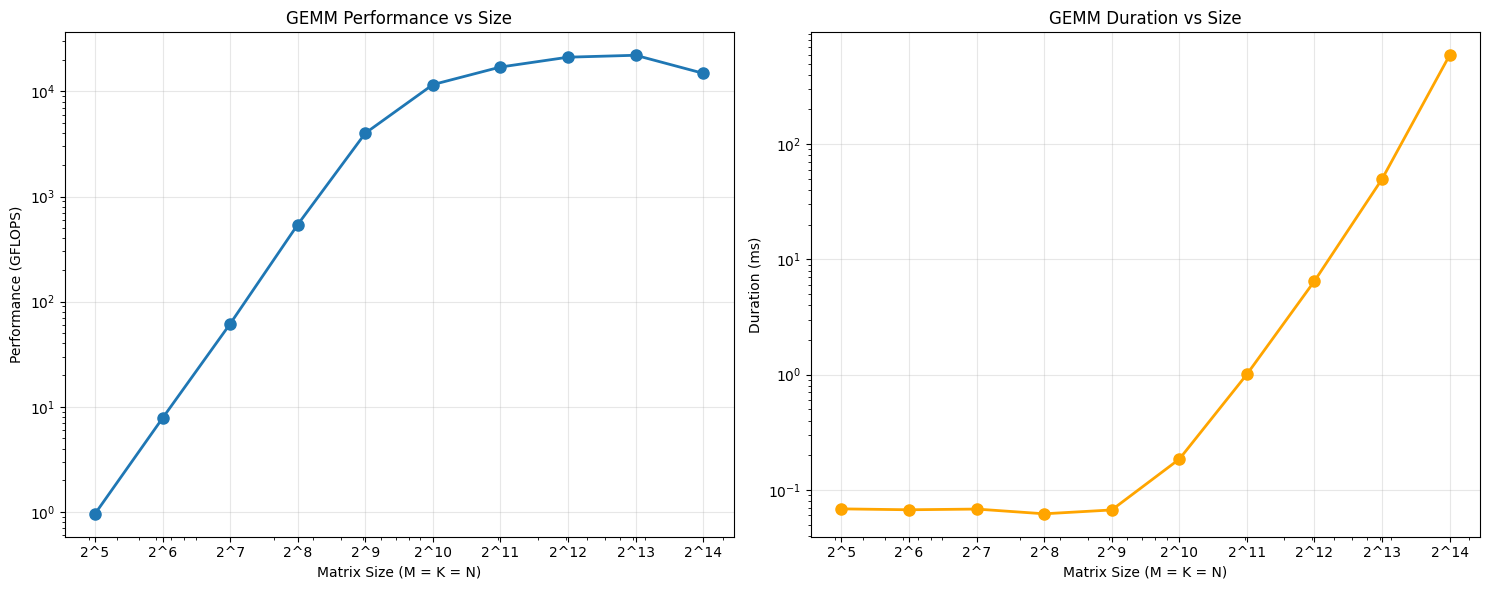

In [5]:
size_df=run_experiments()